In [1]:
from WindowSegmentation import SlidingWindow
from Parser import DetectSeizure
import mne
import torch
import numpy as np
import pickle
import os
import gzip
from joblib import dump, load
import pandas as pd
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import gzip
import pickle

Extracting EDF parameters from c:\Users\Karim\Desktop\Summer2023\APS360\downloads\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\Users\Karim\Desktop\Summer2023\APS360\Workspace\Scripts\WindowSegmentation.py:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf("..\..\downloads\chb01_03.edf")


(array([[-4.55189255e-05, -5.25518926e-05, -5.64590965e-05, ...,
         5.25518926e-05,  4.51282051e-05,  4.31746032e-05],
       [-1.34798535e-05, -2.01221001e-05, -1.93406593e-05, ...,
        -4.66910867e-05, -1.77777778e-05,  1.77777778e-05],
       [ 1.11355311e-05,  6.44688645e-06,  4.49328449e-06, ...,
        -4.04395604e-05, -5.80219780e-05, -7.01343101e-05],
       ...,
       [-8.42002442e-05, -6.62271062e-05, -4.82539683e-05, ...,
        -2.79365079e-05, -6.66178266e-05, -1.04517705e-04],
       [-1.95360195e-07,  5.86080586e-07,  6.05616606e-06, ...,
        -8.40048840e-06,  2.12942613e-05,  6.44688645e-06],
       [ 5.02075702e-05,  2.32478632e-05,  4.10256410e-06, ...,
        -9.00610501e-05, -5.17704518e-05, -1.77777778e-05]]), True)


In [2]:
res = os.listdir('..\..\downloads')
counter = 0

window_size = 30 #seconds
shift_step = 10 #seconds
sampling_rate = 256 # hz 
my_data = []

for recording in (res):
    if counter == 4: # Untested, ver seen DATA recording recording 18
        print(recording)
        raw = mne.io.read_raw_edf('..\..\downloads\\'+str(recording))
        data, times = raw[:]
        filename = str(recording)
        counter +=1 
        windows = SlidingWindow(data, (window_size*sampling_rate), (shift_step*sampling_rate)) 
        for i in range(len(windows)):
            window_start_time = i * shift_step
            window_end_time = window_start_time + window_size
            my_data.append((windows[i],DetectSeizure(filename, window_start_time, window_end_time)))
    counter += 1


chb01_18.edf
Extracting EDF parameters from c:\Users\Karim\Desktop\Summer2023\APS360\downloads\chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\Karim\AppData\Local\Temp\ipykernel_7492\512686075.py:12: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf('..\..\downloads\\'+str(recording))


Text(0, 0.5, 'Signal Amplitude (μV)')

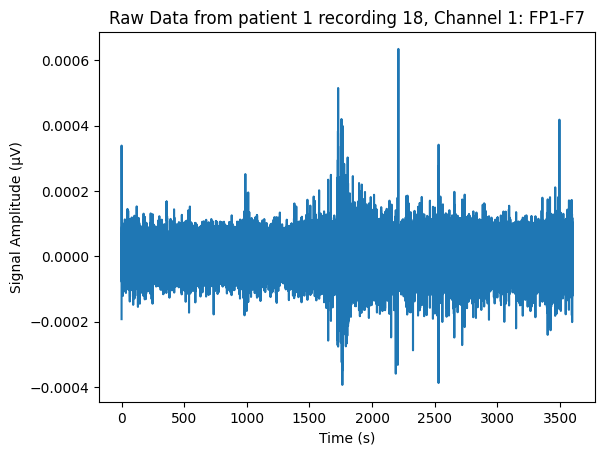

In [6]:
plt.plot(times, data[15]) # channel 1
plt.title("Raw Data from patient 1 recording 18, Channel 1: FP1-F7")
plt.xlabel('Time (s)')
plt.ylabel('Signal Amplitude (μV)')

172 Seizure


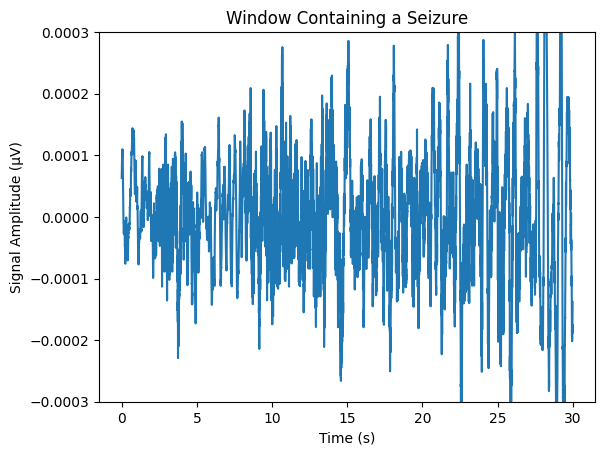

168 Normal


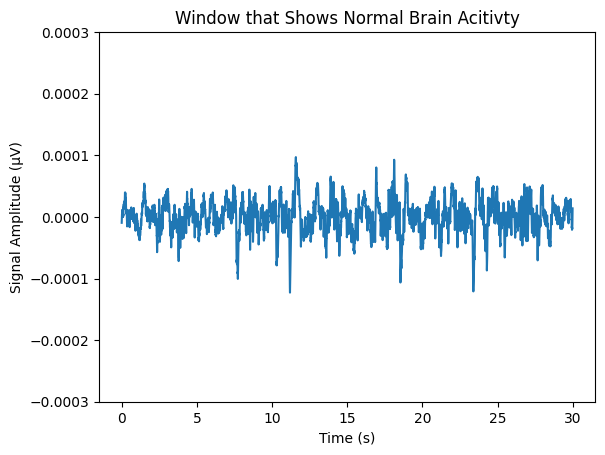

In [4]:
time = np.arange(0, len(my_data[0][0][0])) /sampling_rate
counter = 0
for i in range(len(my_data)):
    if my_data[i][1] ==1:
        print(i+1,"Seizure")
        plt.plot(time, my_data[i+1][0][0])
        plt.ylim(top = 0.0003, bottom = -0.0003)
        plt.title('Window Containing a Seizure')
        plt.xlabel('Time (s)')
        plt.ylabel('Signal Amplitude (μV)')
        plt.show()
        print(i-3,"Normal")
        plt.plot(time, my_data[i-3][0][0])
        plt.ylim(top = 0.0003, bottom = -0.0003)
        plt.title('Window that Shows Normal Brain Acitivty')
        plt.xlabel('Time (s)')
        plt.ylabel('Signal Amplitude (μV)')
        plt.show() 
        counter +=1
    if counter == 1:
        break

In [5]:
print(my_data[0])
print("Number of windows",len(my_data))
print("Length of each tuple (data,label)",len(my_data[0]))
print("Number of channels for each window",len(my_data[0][0]))
print("Number of sampling points per channel",len(my_data[0][0][0]))


(array([[ 3.53601954e-05,  1.95360195e-07,  1.95360195e-07, ...,
         9.57264957e-06,  1.30891331e-05,  1.38705739e-05],
       [ 6.34920635e-05,  1.95360195e-07,  1.95360195e-07, ...,
        -2.14896215e-06, -3.71184371e-06, -1.95360195e-07],
       [-6.83760684e-06,  1.95360195e-07,  1.95360195e-07, ...,
        -2.93040293e-06, -2.93040293e-06, -4.88400488e-06],
       ...,
       [ 1.34798535e-05,  1.95360195e-07,  1.95360195e-07, ...,
         1.23076923e-05,  4.88400488e-06,  1.95360195e-07],
       [ 1.02564103e-04,  1.95360195e-07,  1.95360195e-07, ...,
         1.23076923e-05, -2.93040293e-06, -9.57264957e-06],
       [ 9.76800977e-07,  1.95360195e-07,  1.95360195e-07, ...,
        -1.42612943e-05, -1.89499389e-05, -2.16849817e-05]]), False)
Number of windows 358
Length of each tuple (data,label) 2
Number of channels for each window 23
Number of sampling points per channel 7680


In [6]:
N = len(my_data[0][0][0])
T = 1.0 / 256
x = np.linspace(0.0, N*T, N, endpoint=False)  
feature_data = []
for window in my_data:
    data, label = window
    window_features = []
    for channel in data:
        features = []
        y1 = channel
        yf1 = fft(y1)
        xf1 = fftfreq(N, T)[:N//2]
        features.append((abs(channel).sum()))
        features.append(np.var(channel))
        features.append(np.median((abs((channel)))))
        features.append(np.mean((2.0/N * np.abs(yf1[0:N//2]))[(np.where(xf1 == 0))[0][0]:((np.where(xf1 == 4))[0][0])]))
        features.append(np.mean((2.0/N * np.abs(yf1[0:N//2]))[(np.where(xf1 == 4))[0][0]:((np.where(xf1 == 8))[0][0])]))
        features.append(np.mean((2.0/N * np.abs(yf1[0:N//2]))[(np.where(xf1 == 8))[0][0]:((np.where(xf1 == 12))[0][0])]))
        features.append(np.mean((2.0/N * np.abs(yf1[0:N//2]))[(np.where(xf1 == 12))[0][0]:((np.where(xf1 == 30))[0][0])]))
        features.append(np.mean((2.0/N * np.abs(yf1[0:N//2]))[(np.where(xf1 == 30))[0][0]:((np.where(xf1 == 55))[0][0])]))
        features.append(np.mean((2.0/N * np.abs(yf1[0:N//2]))[(np.where(xf1 == 55))[0][0]:((np.where(xf1 == 61))[0][0])]))
        window_features.append(features)
    feature_data.append((np.array(window_features), label))

In [7]:
print(feature_data[0])
print("Number of windows",len(feature_data))
print("Length of each tuple (data,label)",len(feature_data[0]))
print("Number of channels for each window",len(feature_data[0][0]))
print("Number of sampling points per channel",len(feature_data[0][0][0]))

(array([[8.02617827e-02, 1.91931160e-10, 8.40048840e-06, 1.22282490e-06,
        7.35572052e-07, 2.18050374e-07, 1.71234639e-07, 5.57399198e-08,
        1.61691338e-08],
       [7.26485958e-02, 1.52926052e-10, 7.61904762e-06, 1.11188330e-06,
        6.78410528e-07, 2.46613575e-07, 1.42102666e-07, 4.06739664e-08,
        2.62995442e-08],
       [9.87686447e-02, 2.70200210e-10, 1.07448107e-05, 1.57176574e-06,
        7.96747757e-07, 3.51011909e-07, 1.52075653e-07, 4.00140402e-08,
        8.36416250e-09],
       [1.34711795e-01, 5.17936131e-10, 1.42612943e-05, 2.03229339e-06,
        1.21548035e-06, 5.74465062e-07, 1.76672992e-07, 5.28112109e-08,
        1.22750126e-08],
       [1.12811526e-01, 4.03577164e-10, 1.11355311e-05, 1.84432257e-06,
        1.06997423e-06, 3.19652456e-07, 2.63883605e-07, 5.88782349e-08,
        1.43271998e-08],
       [1.10729377e-01, 3.70900741e-10, 1.11355311e-05, 1.69567975e-06,
        9.90749886e-07, 3.84788435e-07, 2.33981356e-07, 5.06152889e-08,
        7.

In [8]:
with gzip.open('DemonstrationData.pkl', 'wb') as f:
    pickle.dump(feature_data, f)
print("done")

done
